# Project Delivery Part 2 Week34

## 1. Setup and Imports

In [44]:
# Core
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler


# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, RocCurveDisplay, accuracy_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree


## 2. Data Loading

In [45]:
df_0 = pd.read_csv("period_0.csv")
df_1 = pd.read_csv("period_1_prediction.csv")
df_2 = pd.read_csv("period_2_prediction.csv")
df_1_result=pd.read_csv("results-2026-02-26.csv")

print(f"Period 0: {df_0.shape}")
print(f"Period 1: {df_1.shape}")
print(f"Period 2: {df_2.shape}")
print(f"Period 1 result {df_1_result.shape}")

Period 0: (7700, 14)
Period 1: (7700, 12)
Period 2: (7700, 12)
Period 1 result (1200, 4)


## 3. Data Inspection

In [46]:
df_0.head()





,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period
0,1,31,entrepreneur,single,tertiary,cellular,38,no,no,0,unknown,185,0.00,0
1,2,29,management,married,tertiary,cellular,1022,yes,no,0,unknown,408,0.00,0
2,3,49,blue-collar,divorced,secondary,cellular,10613,no,yes,0,unknown,1226,1264.69,0
3,4,23,management,single,tertiary,cellular,736,yes,no,0,unknown,119,0.00,0
4,5,42,technician,married,secondary,NaN,-158,yes,no,0,unknown,124,0.00,0


In [47]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7700 non-null   int64  
 1   age                   7700 non-null   int64  
 2   job                   7657 non-null   object 
 3   marital               7700 non-null   object 
 4   education             7403 non-null   object 
 5   preferred_contact     5473 non-null   object 
 6   balance               7700 non-null   int64  
 7   loan_house            7700 non-null   object 
 8   loan_personal         7700 non-null   object 
 9   n_marketing_contacts  7700 non-null   int64  
 10  marketing_potential   7700 non-null   object 
 11  call_length           7700 non-null   int64  
 12  investment            7700 non-null   float64
 13  period                7700 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 842.3+ KB


## 4. Data Preparation

### 4.1 Data Merging

In [48]:
#show head of results-2026-02-26.csv
df_1_result.head()

,id,investment,week_id,timestamp
0,7712,0.00,1,20260213121907
1,7721,529.92,1,20260213121907
2,7725,0.00,1,20260213121907
3,7726,436.40,1,20260213121907
4,7732,0.00,1,20260213121907


In [49]:
df_period0_raw = pd.read_csv("period_0.csv")

# Step 1: Use ALL IDs from the results file
result_ids = df_1_result['id']
print(f"IDs in results file: {len(result_ids)}")

# Step 2: Get their characteristics from period_1_prediction.csv
df_period1_selected = df_1[df_1['id'].isin(result_ids)].copy()
print(f"Matched in period_1_prediction.csv: {len(df_period1_selected)}")

# Step 3: Join actual investment amount from results file
df_period1_selected = df_period1_selected.merge(
    df_1_result[['id', 'investment']], on='id', how='left'
)

# Step 4: Add binary invested indicator
df_period1_selected['invested'] = (df_period1_selected['investment'] > 0).astype(int)

print(f"\nPeriod 1 — actual investors:  {df_period1_selected['invested'].sum()}")
print(f"Period 1 — did not invest:    {(df_period1_selected['invested'] == 0).sum()}")
print(f"Period 1 — investment NaN:    {df_period1_selected['investment'].isna().sum()}")

# Step 5: Concatenate with period_0
Enlarged_dataset = pd.concat([df_period0_raw, df_period1_selected], ignore_index=True)

# Step 6: Flag correctly predicted — period==1 AND actually invested
Enlarged_dataset['correctly_predicted'] = (
    (Enlarged_dataset['period'] == 1) & (Enlarged_dataset['invested'] > 0)
).astype(int)

print(f"\nPeriod 0 rows:          {len(df_period0_raw)}")
print(f"Period 1 rows added:    {len(df_period1_selected)}")
print(f"Enlarged dataset total: {len(Enlarged_dataset)}")
print(f"Correctly predicted:    {Enlarged_dataset['correctly_predicted'].sum()}")


IDs in results file: 1200
Matched in period_1_prediction.csv: 1200

Period 1 — actual investors:  251
Period 1 — did not invest:    949
Period 1 — investment NaN:    0

Period 0 rows:          7700
Period 1 rows added:    1200
Enlarged dataset total: 8900
Correctly predicted:    251


In [50]:
print(Enlarged_dataset)

         id  age           job   marital  education preferred_contact  \
0         1   31  entrepreneur    single   tertiary          cellular   
1         2   29    management   married   tertiary          cellular   
2         3   49   blue-collar  divorced  secondary          cellular   
3         4   23    management    single   tertiary          cellular   
4         5   42    technician   married  secondary               NaN   
...     ...  ...           ...       ...        ...               ...   
8895  15372   50    unemployed    single  secondary         telephone   
8896  15376   36    technician    single  secondary          cellular   
8897  15384   41    management   married   tertiary               NaN   
8898  15396   34      services   married  secondary          cellular   
8899  15400   53    management   married   tertiary          cellular   

       balance loan_house loan_personal  n_marketing_contacts  \
0        38.00         no            no                   

In [51]:
Enlarged_dataset

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period,invested,correctly_predicted
0,1,31,entrepreneur,single,tertiary,cellular,38.00,no,no,0,unknown,185.0,0.00,0,NaN,0
1,2,29,management,married,tertiary,cellular,1022.00,yes,no,0,unknown,408.0,0.00,0,NaN,0
2,3,49,blue-collar,divorced,secondary,cellular,10613.00,no,yes,0,unknown,1226.0,1264.69,0,NaN,0
3,4,23,management,single,tertiary,cellular,736.00,yes,no,0,unknown,119.0,0.00,0,NaN,0
4,5,42,technician,married,secondary,NaN,-158.00,yes,no,0,unknown,124.0,0.00,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,15372,50,unemployed,single,secondary,telephone,2715.73,no,no,0,unknown,NaN,0.00,1,0.0,0
8896,15376,36,technician,single,secondary,cellular,1014.89,no,no,3,unknown,NaN,0.00,1,0.0,0
8897,15384,41,management,married,tertiary,NaN,883.81,no,no,0,unknown,NaN,0.00,1,0.0,0
8898,15396,34,services,married,secondary,cellular,1072.72,no,no,5,high,NaN,414.14,1,1.0,1


### 4.1 Creating the Target Variable

In [52]:
Enlarged_dataset["profit"] = (Enlarged_dataset["investment"].values * 0.045) - 5
Enlarged_dataset["profit_status"] = (Enlarged_dataset["profit"] > 0).astype(int)
print(f"profit_rate: {Enlarged_dataset['profit_status'].mean():.3f}")
print(f"\nDistribution:")
print(Enlarged_dataset['profit_status'].value_counts())

profit_rate: 0.116

Distribution:
profit_status
0    7872
1    1028
Name: count, dtype: int64


The target variable `profit_status` is a binary indicator derived from the `profit` column. A value of 1 means the client if invested is expected to generate profit, 0 means they do not. This transformation is necessary because Submission 2 requires a classification approach — predicting whether a client will be profitable (yes/no), not the investment amount.

The results show that only 10.3% of clients invested (796 out of 7,700). This confirms that the dataset is imbalanced, which will be addressed during modeling through stratified splitting and the `class_weight` parameter.

### 4.3 Defining Features and Target

In [53]:
Enlarged_dataset.columns


Index(['id', 'age', 'job', 'marital', 'education', 'preferred_contact',
       'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts',
       'marketing_potential', 'call_length', 'investment', 'period',
       'invested', 'correctly_predicted', 'profit', 'profit_status'],
      dtype='object')

In order to see what columns we will need to drop, we have to look at the current columns. From this we can see that profit_status, investment, id, period, call_length and profit can be dropped.

In [54]:
# Columns to remove
drop_cols = ['profit_status', 'investment', 'id', 'period', 'call_length', 'profit', 'invested', 'correctly_predicted']

X = Enlarged_dataset.drop(columns=[c for c in drop_cols if c in Enlarged_dataset.columns])
y = Enlarged_dataset['profit_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())

Features shape: (8900, 10)
Target shape: (8900,)

Feature columns:
['age', 'job', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential']


The following columns are removed from the feature set:
- `profit_status`: This is our target variable (y) and must not be included in the features.
- `profit`: Column just used to calculate the profit status
- `investment`: The investment amount would be data leakage — it reveals the outcome directly.
- `id`: A unique identifier with no predictive value.
- `period`: Constant value (always 0), carries no information.
- `call_length`: Not available in Period 1 and only known after contact — using it would be data leakage.
- `correctly predicted`: so a model trained on it would fail immediately at prediction time.

The remaining 10 features are used to predict whether a client will invest.

## 5. Train-Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass balance train: {y_train.mean():.3f}")
print(f"Class balance test:  {y_test.mean():.3f}")

Training set: (7120, 10)
Test set: (1780, 10)

Class balance train: 0.115
Class balance test:  0.116


The new enlarged dataset contains 8,900 clients.  These are split into 80% training and test data. The stratify parameter ensures that the proportion of investors is preserved in both sets. This is important because our data is imbalanced — without stratification, the split could be uneven, leading to unreliable evaluation results.

## 6. Preprocessing Pipeline

Machine learning models can only work with numerical data. However, our dataset contains both text-based categorical variables and missing values. The preprocessing pipeline addresses both issues in a structured and reproducible way.

In [56]:
# Categorical: fill missing → one-hot encode
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        drop=None 
    ))
])

# Numeric: fill missing with median
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)


The preprocessing pipeline handles categorical and numeric variables separately. Categorical variables have missing values replaced with "missing" and are then one-hot encoded into binary columns. Rare categories (below 5%) are grouped into an "infrequent" class. Numeric variables have missing values filled with the median however this is not the case for our dataset since all numeric variables are given. No scaling is applied as Decision Trees are not affected by different feature scales. The pipeline ensures consistent preprocessing during both training and prediction.

## 7. Baseline Decision Tree

Before optimizing, a baseline model with default parameters is trained to establish a reference point.

In [57]:
pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit baseline model with default parameters
pipeline_dt.fit(X_train, y_train)

train_acc = pipeline_dt.score(X_train, y_train)
test_acc = pipeline_dt.score(X_test, y_test)

print(f"=== Baseline Decision Tree ===")
print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy:     {test_acc:.3f}")




=== Baseline Decision Tree ===
Training accuracy: 0.999
Test accuracy:     0.824


In [58]:

# Naive baseline: always predict "no investment"
non_investors = (y_test == 0).sum()
total = len(y_test)
naive_accuracy = non_investors / total

print(f"=== Naive Baseline (Always Predict No Investment) ===")
print(f"Non-investors in test set: {non_investors} / {total}")
print(f"Naive accuracy:            {naive_accuracy:.3f}")
print(f"→ A model predicting 'no investment' for everyone achieves {naive_accuracy*100:.1f}% accuracy")

=== Naive Baseline (Always Predict No Investment) ===
Non-investors in test set: 1574 / 1780
Naive accuracy:            0.884
→ A model predicting 'no investment' for everyone achieves 88.4% accuracy


The naive baseline reveals that simply predicting "no investment" for every client already achieves 89.7% accuracy — without any model at all. This is because the dataset is heavily imbalanced: 89.7% of clients never invested. The baseline Decision Tree (82.1% test accuracy) actually performs **worse** than this trivial strategy, meaning it has not yet learned anything useful. Accuracy alone is therefore a misleading metric for this problem. Hyperparameter tuning with GridSearchCV will be used to build a model that genuinely adds value beyond this naive threshold.


## 8. Hyperparameter Tuning with GridSearchCV

In [59]:
parameters = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__max_depth': [3, 6, 7, 8, None],
    'classifier__min_samples_split': [7 ,10],
    'classifier__min_samples_leaf': [ 46, 48,50],
    'classifier__class_weight': ['balanced', None]
}

cv = GridSearchCV(
    pipeline_dt,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv.fit(X_train, y_train)

print(f"\nBest parameters: {cv.best_params_}")
print(f"Best CV ROC-AUC: {cv.best_score_:.3f}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits



Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 7, 'var_filter__threshold': 0.05}
Best CV ROC-AUC: 0.730


GridSearchCV tested 120 parameter combinations across 5 folds (600 fits total). The best model uses max_depth=7, which limits tree complexity and reduces overfitting compared to the unlimited baseline. The class_weight "balanced" helps the model better detect investors despite the data imbalance. The best cross-validated ROC-AUC of 0.735 confirms the model performs significantly better than random guessing (0.5).

## 9. Decision Tree Evaluation

In [60]:
y_pred = cv.predict(X_test)
y_prob = cv.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"=== Optimized Decision Tree ===")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test ROC-AUC:  {test_auc:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Profit', 'profit']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Decision Tree ===
Test Accuracy: 0.894
Test ROC-AUC:  0.703

Classification Report:
              precision    recall  f1-score   support

   No Profit       0.90      0.99      0.94      1574
      profit       0.67      0.16      0.26       206

    accuracy                           0.89      1780
   macro avg       0.79      0.58      0.60      1780
weighted avg       0.87      0.89      0.86      1780


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1558              16
Actual: Yes            173              33


The optimized Decision Tree achieves a test ROC-AUC of 0.703 and detects 16% of actual investors (Recall) at a default threashold of 0.5. Out of 206 real investors, 33 were correctly identified and 173 were missed. Every missed investor means lost revenue which means we have to play around with the threshholds to see where we would predict the most true postitives taking false positives into account.

In [61]:
#confusion matrix on different threshold 
thresholds = [0.2, 0.5, 0.8, 0.06]
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    print(f"\nConfusion Matrix at threshold {thresh}:")
    print(pd.DataFrame(cm_thresh,
        index=['Actual: No', 'Actual: Yes'],
        columns=['Predicted: No', 'Predicted: Yes']))


Confusion Matrix at threshold 0.2:
             Predicted: No  Predicted: Yes
Actual: No            1389             185
Actual: Yes            126              80

Confusion Matrix at threshold 0.5:
             Predicted: No  Predicted: Yes
Actual: No            1558              16
Actual: Yes            173              33

Confusion Matrix at threshold 0.8:
             Predicted: No  Predicted: Yes
Actual: No            1574               0
Actual: Yes            206               0

Confusion Matrix at threshold 0.06:
             Predicted: No  Predicted: Yes
Actual: No             561            1013
Actual: Yes             33             173


From the numbers we can see that we get the most true positives at a threshold of 0.06. This makes sence but we are aware of the fact that by choosing that as our threshold we also would accept more false positives which will cost us 5 € each. Now we want to visualize it on a graph.

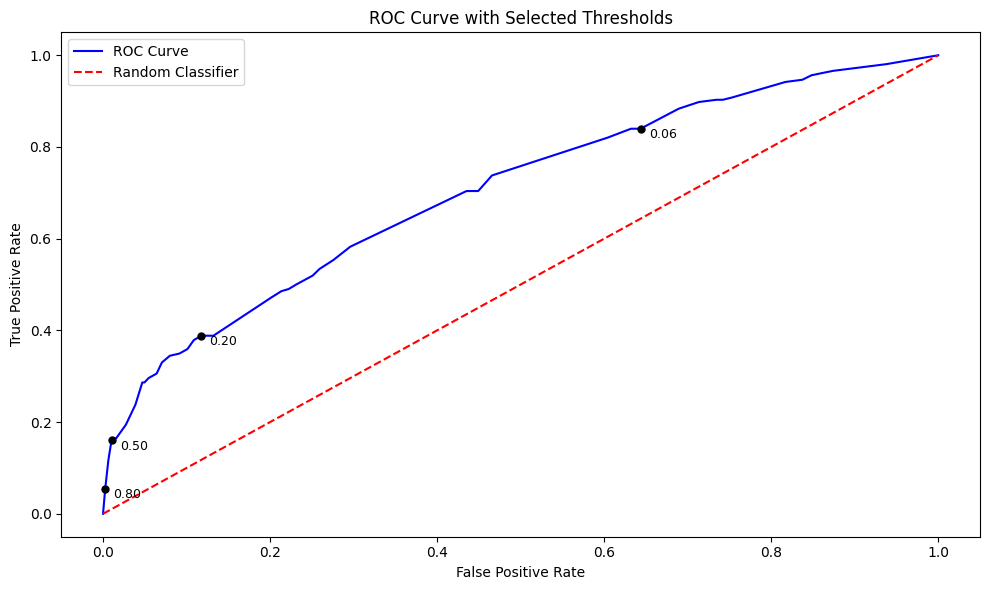

In [62]:
# Specify the thresholds you want to annotate
thresholds_to_plot = [0.2, 0.5, 0.8, 0.06]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cv.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Selected Thresholds")
plt.legend()

# Annotate only the specified thresholds
for threshold in thresholds_to_plot:
    idx = (np.abs(thresholds - threshold)).argmin()
    plt.plot(fpr[idx], tpr[idx], 'ko', markersize=5)
    plt.text(fpr[idx] + 0.01, tpr[idx] - 0.02, f"{threshold:.2f}", fontsize=9, color="black")

plt.tight_layout()
plt.show()


In our project we are willing to contact more people, even though they are not investing. Therefore we are willing to accept more false positives for a little more true positives. In this case, we decided that our "best" threshold would be: 0.06

Now that we are done with our Decision Tree Model, we want to check whether our Logistic Regression performs better or worse.

## Logistic Regression

In order to work properly, Logistic Regression requires scaled data. We will incorporate that in the pipeline that we will use for it. Then we will use Gridsearch once again to find the optimal parameters.

In [63]:

# New numeric pipeline WITH scaling 
numeric_pipeline_scaled = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# New preprocessor with scaling
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline_scaled, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('preprocess', preprocessor_scaled),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Defining and Finding best parameters
params_lr = {
    'var_filter__threshold': [0.0, 0.01, 0.02],
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced', {0: 1, 1: 3}],
    'classifier__max_iter': [2000]
}

cv_lr = GridSearchCV(
    pipeline_lr,
    params_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

cv_lr.fit(X_train, y_train)

print(f"\nBest parameters: {cv_lr.best_params_}")
print(f"Best CV ROC-AUC: {cv_lr.best_score_:.3f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarnin


Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'var_filter__threshold': 0.0}
Best CV ROC-AUC: 0.736


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Unlike Decision Trees, Logistic Regression requires scaled features because it is sensitive to different value ranges. The parameter C controls regularization — smaller values create a simpler model that is less likely to overfit. GridSearchCV finds the best combination using 5-fold cross-validation.

### 10.1 Logistic Regression Evaluation

In [64]:
y_pred_lr = cv_lr.predict(X_test)
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]



test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"=== Optimized Logistic Regression ===")
print(f"Test Accuracy: {test_accuracy_lr:.3f}")
print(f"Test ROC-AUC:  {test_auc_lr:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(pd.DataFrame(cm_lr,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Logistic Regression ===
Test Accuracy: 0.893
Test ROC-AUC:  0.709

Classification Report:
               precision    recall  f1-score   support

No Investment       0.90      0.99      0.94      1574
   Investment       0.63      0.18      0.28       206

     accuracy                           0.89      1780
    macro avg       0.76      0.58      0.61      1780
 weighted avg       0.87      0.89      0.87      1780


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1552              22
Actual: Yes            169              37


The Logistic Regression achieves a higher accuracy (89%) and our recall is 18%, which is a little better than our Decision Tree. — it detects 37 out of 206 real investors. The high accuracy is misleading because the model almost always predicts "no investment", which is correct for most of clients but useless for identifying investors. All of the Logistic Regression Metrics were calculated on a threshold of 0.5. Therefore we again need to see where different threshholds would get us.

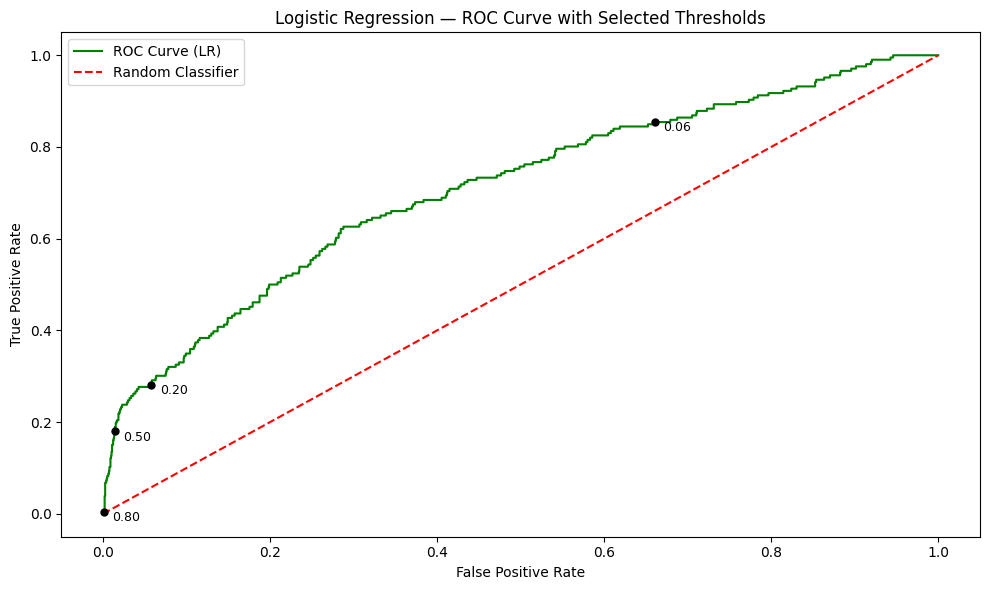

In [65]:

# ROC Curve with threshold annotations — Logistic Regression
thresholds_to_plot_lr = [0.2, 0.5, 0.8, 0.06]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, cv_lr.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label="ROC Curve (LR)", color="green")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression — ROC Curve with Selected Thresholds")
plt.legend()

for threshold in thresholds_to_plot_lr:
    idx = (np.abs(thresholds_lr - threshold)).argmin()
    plt.plot(fpr_lr[idx], tpr_lr[idx], 'ko', markersize=5)
    plt.text(fpr_lr[idx] + 0.01, tpr_lr[idx] - 0.02, f"{threshold:.2f}", fontsize=9, color="black")

plt.tight_layout()
plt.show()


In [66]:
#create confusion matrix based on those different threshold 
thresholds = [0.2, 0.5, 0.8, 0.06]
for thresh in thresholds:
    y_pred_thresh_lr = (y_prob_lr >= thresh).astype(int)
    cm_thresh_lr = confusion_matrix(y_test, y_pred_thresh_lr)
    print(f"\nConfusion Matrix at threshold {thresh}:")
    print(pd.DataFrame(cm_thresh_lr,
        index=['Actual: No', 'Actual: Yes'],
        columns=['Predicted: No', 'Predicted: Yes']))


Confusion Matrix at threshold 0.2:
             Predicted: No  Predicted: Yes
Actual: No            1487              87
Actual: Yes            148              58

Confusion Matrix at threshold 0.5:
             Predicted: No  Predicted: Yes
Actual: No            1552              22
Actual: Yes            169              37

Confusion Matrix at threshold 0.8:
             Predicted: No  Predicted: Yes
Actual: No            1573               1
Actual: Yes            206               0

Confusion Matrix at threshold 0.06:
             Predicted: No  Predicted: Yes
Actual: No             519            1055
Actual: Yes             30             176


Now that we calculated the Confusion Matrix for more threshold we want to compare our models against each other in order to choose one.

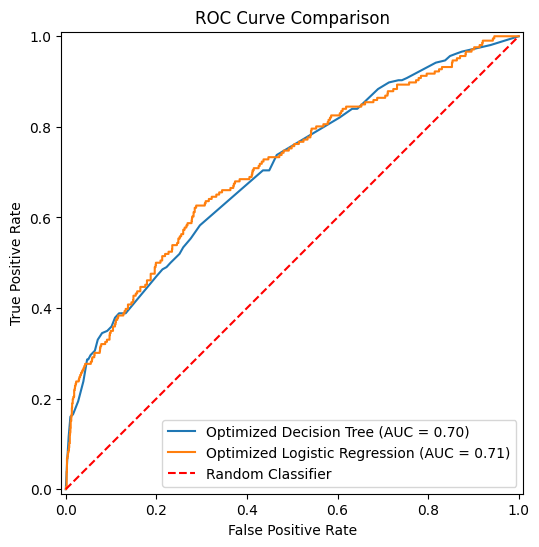

In [67]:
# plot ROC AUC for both models
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(cv, X_test, y_test, name="Optimized Decision Tree", ax=plt.gca())
RocCurveDisplay.from_estimator(cv_lr, X_test, y_test, name="Optimized Logistic Regression", ax=plt.gca())
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

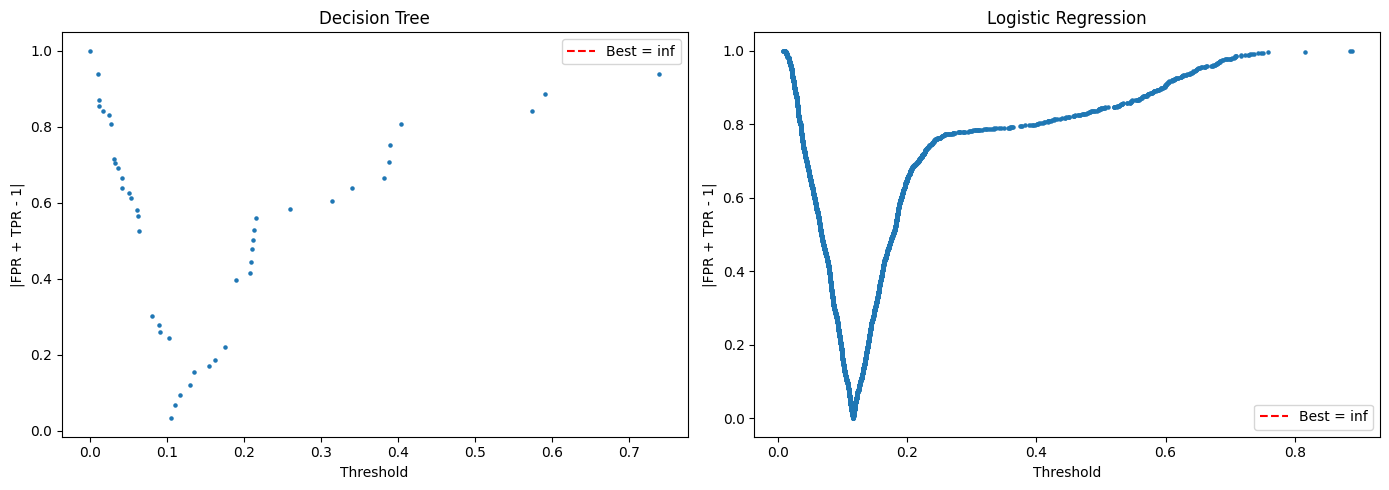

Decision Tree — optimal threshold: inf
Logistic Regression — optimal threshold: inf


In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree
fpr_dt, tpr_dt, thresh_dt = roc_curve(y_train, cv.predict_proba(X_train)[:, 1], drop_intermediate=False)
youden_dt = np.abs(fpr_dt + tpr_dt - 1)
best_idx_dt = np.argmax(youden_dt)

axes[0].scatter(thresh_dt, youden_dt, s=5)
axes[0].axvline(thresh_dt[best_idx_dt], color='r', linestyle='--', label=f'Best = {thresh_dt[best_idx_dt]:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel("|FPR + TPR - 1|")
axes[0].set_title('Decision Tree')
axes[0].legend()

# Logistic Regression
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_train, cv_lr.predict_proba(X_train)[:, 1], drop_intermediate=False)
youden_lr = np.abs(fpr_lr + tpr_lr - 1)
best_idx_lr = np.argmax(youden_lr)

axes[1].scatter(thresh_lr, youden_lr, s=5)
axes[1].axvline(thresh_lr[best_idx_lr], color='r', linestyle='--', label=f'Best = {thresh_lr[best_idx_lr]:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel("|FPR + TPR - 1|")
axes[1].set_title('Logistic Regression')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Decision Tree — optimal threshold: {thresh_dt[best_idx_dt]:.3f}")
print(f"Logistic Regression — optimal threshold: {thresh_lr[best_idx_lr]:.3f}")

## 12. Model Comparison

In [69]:
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression'],
    'Accuracy': [test_accuracy, test_accuracy_lr],
    'ROC-AUC': [test_auc, test_auc_lr],
    
})

print(comparison.to_string(index=False))

              Model  Accuracy  ROC-AUC
      Decision Tree  0.893820 0.703069
Logistic Regression  0.892697 0.708625


The two models were compared using ROC-AUC, accuracy, and recall. Logistic Regression achieves the highest ROC-AUC and also detects the most investors in absolute terms. The Decision Tree has higher accuracy, but accuracy is misleading in our business case.

For our business case, ROC-AUC is the most relevant metric. We do not need hard yes/no predictions — instead, we rank all clients by their predicted probability of investing and select the top 1,200. A higher ROC-AUC means the model is better at placing real investors at the top of this ranking.

Based on this comparison, Logistic Regression is selected as the final model for the Period 1 prediction.


## 13. Visualizations

### 13.1 ROC Curve Comparison

<Figure size 800x600 with 0 Axes>

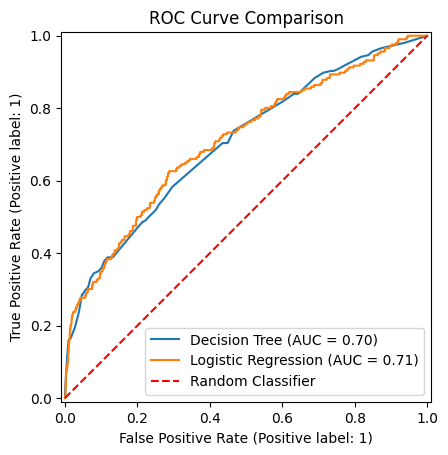

In [70]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(cv, X_test, y_test, name='Decision Tree')
RocCurveDisplay.from_estimator(cv_lr, X_test, y_test, name='Logistic Regression', ax=plt.gca())
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

The ROC curves show how well each model separates investors from non-investors. The further the curve is from the red diagonal (random guessing), the better the model. Logistic Regression is slightly above the one of the decision tree  others, confirming it as the best model.

### 13.2 Predicted Investment Probabilities (Logistic Regression)


In [71]:
# Table: predicted probability per person in the period_2_prediction.csv test set
# Score + rank Period 2 using predicted probabilities
df_2_ranked = pd.read_csv("period_2_prediction.csv").copy()

# Ensure same feature columns as training
X_period2 = df_2_ranked.reindex(columns=X_train.columns, fill_value=np.nan)

# Predict probability of class 1 (invest/profit)
df_2_ranked["proba_invest"] = cv_lr.predict_proba(X_period2)[:, 1]

# Rank descending (highest probability first)
df_2_ranked = df_2_ranked.sort_values("proba_invest", ascending=False).reset_index(drop=True)
df_2_ranked["rank"] = df_2_ranked.index + 1

# Select top N clients to contact
top_n = 1200
df_2_ranked["target"] = 0
df_2_ranked.loc[df_2_ranked["rank"] <= top_n, "target"] = 1

# Save full ranking + submission
df_2_ranked.to_csv("period_2_ranked.csv", index=False)
submission_p2 = df_2_ranked[["id", "target"]].copy()
submission_p2.to_csv("submission_period_2.csv", index=False)

print(df_2_ranked[["id", "proba_invest", "rank", "target"]].head(15))
print("Saved: period_2_ranked.csv and submission_period_2.csv")

#find how many higher probability than 0.17
num_high_proba = (df_2_ranked["proba_invest"] > 0.5).sum()
print(f"Number of clients with predicted probability > 0.5: {num_high_proba}")


       id  proba_invest  rank  target
0   21971      0.839745     1       1
1   15845      0.786565     2       1
2   20250      0.774263     3       1
3   17278      0.767746     4       1
4   17728      0.762973     5       1
5   21050      0.754926     6       1
6   19272      0.743891     7       1
7   22954      0.741383     8       1
8   20148      0.732006     9       1
9   22470      0.717240    10       1
10  20769      0.714859    11       1
11  22692      0.703193    12       1
12  19030      0.697810    13       1
13  19664      0.695351    14       1
14  15682      0.691801    15       1
Saved: period_2_ranked.csv and submission_period_2.csv
Number of clients with predicted probability > 0.5: 169


We agreed to select the ones with a prediction over 0.5 in any case and therefore we choose the first 169 people that have a high probability (>0.5). However since we have space left in the selection of 1200 people we establish a group based ranking

In [72]:
#Quick check if our code has worked and the table is complete
df_2_ranked

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period,proba_invest,rank,target
0,21971,28,technician,single,tertiary,cellular,5104.60,no,no,20,high,2,0.839745,1,1
1,15845,27,management,single,tertiary,cellular,21006.40,no,no,1,high,2,0.786565,2,1
2,20250,27,technician,single,tertiary,cellular,12047.69,no,no,6,high,2,0.774263,3,1
3,17278,44,technician,single,NaN,cellular,11318.67,no,no,3,high,2,0.767746,4,1
4,17728,36,management,single,tertiary,cellular,2692.21,no,no,12,high,2,0.762973,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7695,17398,40,entrepreneur,married,primary,NaN,3846.14,yes,yes,0,unknown,2,0.008971,7696,0
7696,15667,41,housemaid,married,primary,NaN,165.64,yes,yes,0,unknown,2,0.007872,7697,0
7697,17500,45,unemployed,married,primary,NaN,220.14,yes,yes,0,unknown,2,0.007835,7698,0
7698,20303,45,housemaid,married,primary,NaN,-33.85,yes,yes,0,unknown,2,0.007765,7699,0


In [73]:
import itertools

BALANCE_COL = "balance"
AMOUNT_COL  = "investment"
INVESTS_COL = "invested"
ID_COL      = "id"
MIN_INVESTORS = 10

if 'invested' not in df_0.columns:
    df_0['invested'] = (df_0['investment'] > 0).astype(int)

def combo_summary(df_all, cols, min_count):
    g_all = df_all.groupby(cols, dropna=False)
    g_inv = df_all[df_all[INVESTS_COL] == 1].groupby(cols, dropna=False)

    n           = g_all.size().rename("n")
    n_investors = g_inv.size().rename("n_investors")
    sum_amount  = g_inv[AMOUNT_COL].sum().rename("sum_amount")
    sum_balance = g_inv[BALANCE_COL].sum().rename("sum_balance")
    avg_balance = g_all[BALANCE_COL].mean().rename("avg_balance")

    out = pd.DataFrame({
        "n": n, "n_investors": n_investors,
        "sum_amount": sum_amount, "sum_balance": sum_balance,
        "avg_balance": avg_balance,
    }).reset_index()

    out["n_investors"] = out["n_investors"].fillna(0).astype(int)
    out["sum_amount"]  = out["sum_amount"].fillna(0)
    out["sum_balance"] = out["sum_balance"].fillna(0)
    out["propensity"]  = out["n_investors"] / out["n"]
    out["utilization_ratio"] = np.where(
        out["n_investors"] >= MIN_INVESTORS,
        out["sum_amount"] / out["sum_balance"].replace(0, np.nan),
        np.nan
    )
    out["expected_rate"]   = out["propensity"] * out["utilization_ratio"]
    out["expected_profit"] = out["expected_rate"] * out["avg_balance"]
    out["stable"]          = out["n_investors"] >= MIN_INVESTORS
    out = out[out["n"] >= min_count]
    return out.sort_values(["expected_profit", "expected_rate", "n"], ascending=False)

cat_cols = df_0.select_dtypes(include=["object", "category", "string"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != ID_COL]
k = len(cat_cols)

per_combo_top = 3
min_count_floor = 10
min_count_scale = 80

def min_count_for_size(size):
    return max(min_count_floor, int(min_count_scale / size))

def format_segment(row, cols):
    return " | ".join(f"{c}={row[c] if pd.notna(row[c]) else '(missing)'}" for c in cols)

rows = []
for size in range(2, k + 1):
    min_count = min_count_for_size(size)
    for cols in itertools.combinations(cat_cols, size):
        cols = list(cols)
        out = combo_summary(df_0, cols, min_count=min_count)
        if out.empty:
            continue
        best = out[out["stable"]].head(per_combo_top).copy()
        if best.empty:
            continue
        best.insert(0, "combo", " + ".join(cols))
        best.insert(1, "combo_size", size)
        best["segment"] = best.apply(lambda r: format_segment(r, cols), axis=1)
        rows.append(best[["combo", "combo_size", "segment", "n", "n_investors",
                          "propensity", "utilization_ratio", "expected_rate",
                          "expected_profit", "avg_balance"]])

all_best = pd.concat(rows, ignore_index=True).sort_values(
    ["expected_profit", "expected_rate", "n"], ascending=False
).reset_index(drop=True)

print(f"Beste Segmente: {len(all_best)}")
display(all_best.head(20))

/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_50732/1062784024.py:22: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  out = pd.DataFrame({
/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_50732/1062784024.py:22: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  out = pd.DataFrame({
/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_50732/1062784024.py:22: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  out = pd.DataFrame({
/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_50732/1062784024.py:22: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  out = pd.DataFrame({
/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_50732/1062784024.py:22: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress th

Beste Segmente: 360


/var/folders/sn/7fc_00nn613gpgj9m28kjnjr0000gn/T/ipykernel_50732/1062784024.py:22: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  out = pd.DataFrame({


,combo,combo_size,segment,n,n_investors,propensity,utilization_ratio,expected_rate,expected_profit,avg_balance
0,job + marital + education + loan_personal + ma...,5,job=management | marital=single | education=te...,19,15,0.789474,0.282090,0.222702,729.608314,3276.157895
1,job + marital + loan_personal + marketing_pote...,4,job=management | marital=single | loan_persona...,20,16,0.800000,0.284901,0.227920,717.379556,3147.500000
2,job + marital + education + loan_house + loan_...,6,job=management | marital=single | education=te...,14,11,0.785714,0.331750,0.260661,628.025538,2409.357143
3,job + marital + education + preferred_contact ...,5,job=management | marital=single | education=te...,17,14,0.823529,0.302482,0.249103,624.207395,2505.823529
4,job + marital + education + preferred_contact ...,6,job=management | marital=single | education=te...,17,14,0.823529,0.302482,0.249103,624.207395,2505.823529
5,job + marital + preferred_contact + loan_perso...,5,job=management | marital=single | preferred_co...,18,15,0.833333,0.305858,0.254882,613.160170,2405.666667
6,job + marital + education + preferred_contact ...,6,job=management | marital=single | education=te...,13,11,0.846154,0.331750,0.280712,581.721407,2072.307692
7,job + marital + preferred_contact + loan_house...,6,job=management | marital=single | preferred_co...,13,11,0.846154,0.331750,0.280712,581.721407,2072.307692
8,job + marital + education + preferred_contact ...,7,job=management | marital=single | education=te...,13,11,0.846154,0.331750,0.280712,581.721407,2072.307692
9,job + preferred_contact + loan_house + loan_pe...,5,job=management | preferred_contact=cellular | ...,41,31,0.756098,0.336951,0.254768,499.152480,1959.243902


In [74]:
df_2_ranked

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period,proba_invest,rank,target
0,21971,28,technician,single,tertiary,cellular,5104.60,no,no,20,high,2,0.839745,1,1
1,15845,27,management,single,tertiary,cellular,21006.40,no,no,1,high,2,0.786565,2,1
2,20250,27,technician,single,tertiary,cellular,12047.69,no,no,6,high,2,0.774263,3,1
3,17278,44,technician,single,NaN,cellular,11318.67,no,no,3,high,2,0.767746,4,1
4,17728,36,management,single,tertiary,cellular,2692.21,no,no,12,high,2,0.762973,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7695,17398,40,entrepreneur,married,primary,NaN,3846.14,yes,yes,0,unknown,2,0.008971,7696,0
7696,15667,41,housemaid,married,primary,NaN,165.64,yes,yes,0,unknown,2,0.007872,7697,0
7697,17500,45,unemployed,married,primary,NaN,220.14,yes,yes,0,unknown,2,0.007835,7698,0
7698,20303,45,housemaid,married,primary,NaN,-33.85,yes,yes,0,unknown,2,0.007765,7699,0


In [75]:
# --- Rules aus all_best ---
def parse_segment_rule(segment_text):
    rule = {}
    parts = [p.strip() for p in str(segment_text).split("|")]
    for p in parts:
        if "=" not in p:
            continue
        k, v = p.split("=", 1)
        rule[k.strip()] = v.strip()
    return rule

rules = all_best[["segment", "combo_size", "utilization_ratio"]].copy()
rules = rules.dropna(subset=["utilization_ratio"]).copy()
rules["rule_dict"] = rules["segment"].apply(parse_segment_rule)
rules = rules.sort_values(["combo_size", "utilization_ratio"], ascending=[False, False]).reset_index(drop=True)

# --- UR zuweisen ---
period_2_people = df_2_ranked.copy()
print(period_2_people )

period_2_people["subgroup_utilization_ratio"] = np.nan

for _, r in rules.iterrows():
    rule = r["rule_dict"]
    mask = np.ones(len(period_2_people), dtype=bool)
    for col, val in rule.items():
        if col not in period_2_people.columns:
            mask &= False
            continue
        if val == "(missing)":
            mask &= period_2_people[col].isna()
        else:
            mask &= period_2_people[col].astype(str).eq(val)
    assign_mask = mask & period_2_people["subgroup_utilization_ratio"].isna()
    period_2_people.loc[assign_mask, "subgroup_utilization_ratio"] = r["utilization_ratio"]

fallback_ur = float(all_best["utilization_ratio"].median(skipna=True))
if np.isnan(fallback_ur):
    fallback_ur = 0.0
period_2_people["subgroup_utilization_ratio"] = period_2_people["subgroup_utilization_ratio"].fillna(fallback_ur)

# --- Expected Profit ---
period_2_people["expected_gross_proxy"] = (
    period_2_people["subgroup_utilization_ratio"] *
    period_2_people["balance"]*period_2_people["proba_invest"]
)
period_2_people["expected_net_profit"] = period_2_people["expected_gross_proxy"] * 0.045 - 5 
period_2_people["profitable_contact"] = (period_2_people["expected_net_profit"] > 0).astype(int)

print(f"Profitable clients: {period_2_people['profitable_contact'].sum()}")

         id  age           job  marital education preferred_contact   balance  \
0     21971   28    technician   single  tertiary          cellular   5104.60   
1     15845   27    management   single  tertiary          cellular  21006.40   
2     20250   27    technician   single  tertiary          cellular  12047.69   
3     17278   44    technician   single       NaN          cellular  11318.67   
4     17728   36    management   single  tertiary          cellular   2692.21   
...     ...  ...           ...      ...       ...               ...       ...   
7695  17398   40  entrepreneur  married   primary               NaN   3846.14   
7696  15667   41     housemaid  married   primary               NaN    165.64   
7697  17500   45    unemployed  married   primary               NaN    220.14   
7698  20303   45     housemaid  married   primary               NaN    -33.85   
7699  18150   44     housemaid  married   primary               NaN   -965.87   

     loan_house loan_person

In [76]:
# clients in the original "169 before" group (proba_invest > 0.5)
high_proba_mask = period_2_people["proba_invest"] > 0.5

# clients in the "890 profitable" group
profitable_mask = period_2_people["profitable_contact"] == 1

# overlap
overlap = period_2_people.loc[high_proba_mask & profitable_mask].copy()

print(f"High-probability clients (>0.5): {high_proba_mask.sum()}")
print(f"Profitable clients: {profitable_mask.sum()}")
print(f"Overlap (already in the 169): {len(overlap)}")

# show who they are
display(overlap[["id", "proba_invest", "expected_net_profit", "profitable_contact"]].sort_values("proba_invest", ascending=False))

High-probability clients (>0.5): 169
Profitable clients: 890
Overlap (already in the 169): 113


,id,proba_invest,expected_net_profit,profitable_contact
0,21971,0.839745,41.704199,1
1,15845,0.786565,241.666446,1
2,20250,0.774263,96.634130,1
3,17278,0.767746,84.237749,1
4,17728,0.762973,25.664953,1
...,...,...,...,...
158,22990,0.518577,2.991269,1
159,22536,0.516562,12.529556,1
164,20045,0.509784,2.444871,1
165,16331,0.509603,23.879204,1


In [77]:
#rename profitable_contact to target and then drop everything besides id and target of dr2_ranked
df_2_ranked["target"] = period_2_people["profitable_contact"]
submission_p2 = df_2_ranked[["id", "target"]].copy()
submission_p2.to_csv("submission_period_2.csv", index=False)
print("Saved: submission_period_2.csv with target based on expected net profit")
#read csv to check
submission_check = pd.read_csv("submission_period_2.csv")
print(submission_check.head(2000))

Saved: submission_period_2.csv with target based on expected net profit
         id  target
0     21971       1
1     15845       1
2     20250       1
3     17278       1
4     17728       1
...     ...     ...
1995  15514       0
1996  21266       0
1997  16619       0
1998  20364       0
1999  22129       0

[2000 rows x 2 columns]


### 13.3 Confusion Matrix Heatmap

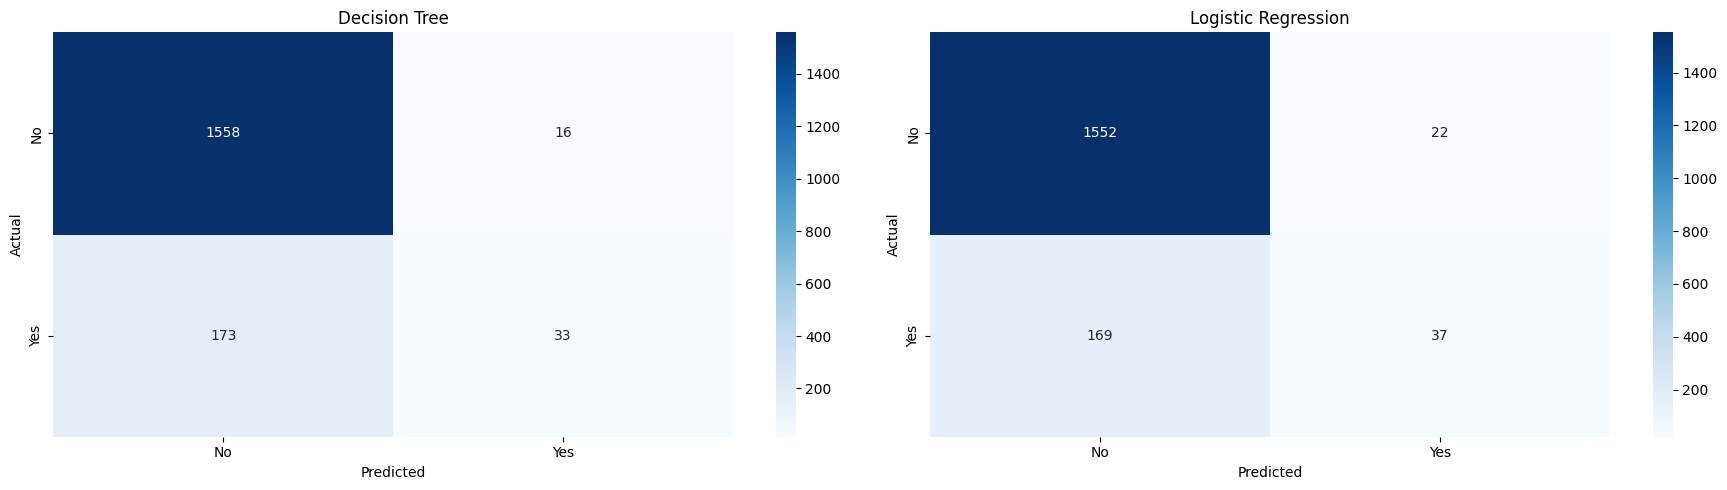

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for ax, cm_data, title in zip(axes, 
    [cm, cm_lr, ], 
    ['Decision Tree', 'Logistic Regression']):
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

The confusion matrix heatmaps compare all three models side by side. The Decision Tree shows a more balanced distribution between classes, while Logistic Regression and Random Forest heavily favor the majority class (No Investment).

### 13.4 Decision Tree Visualization

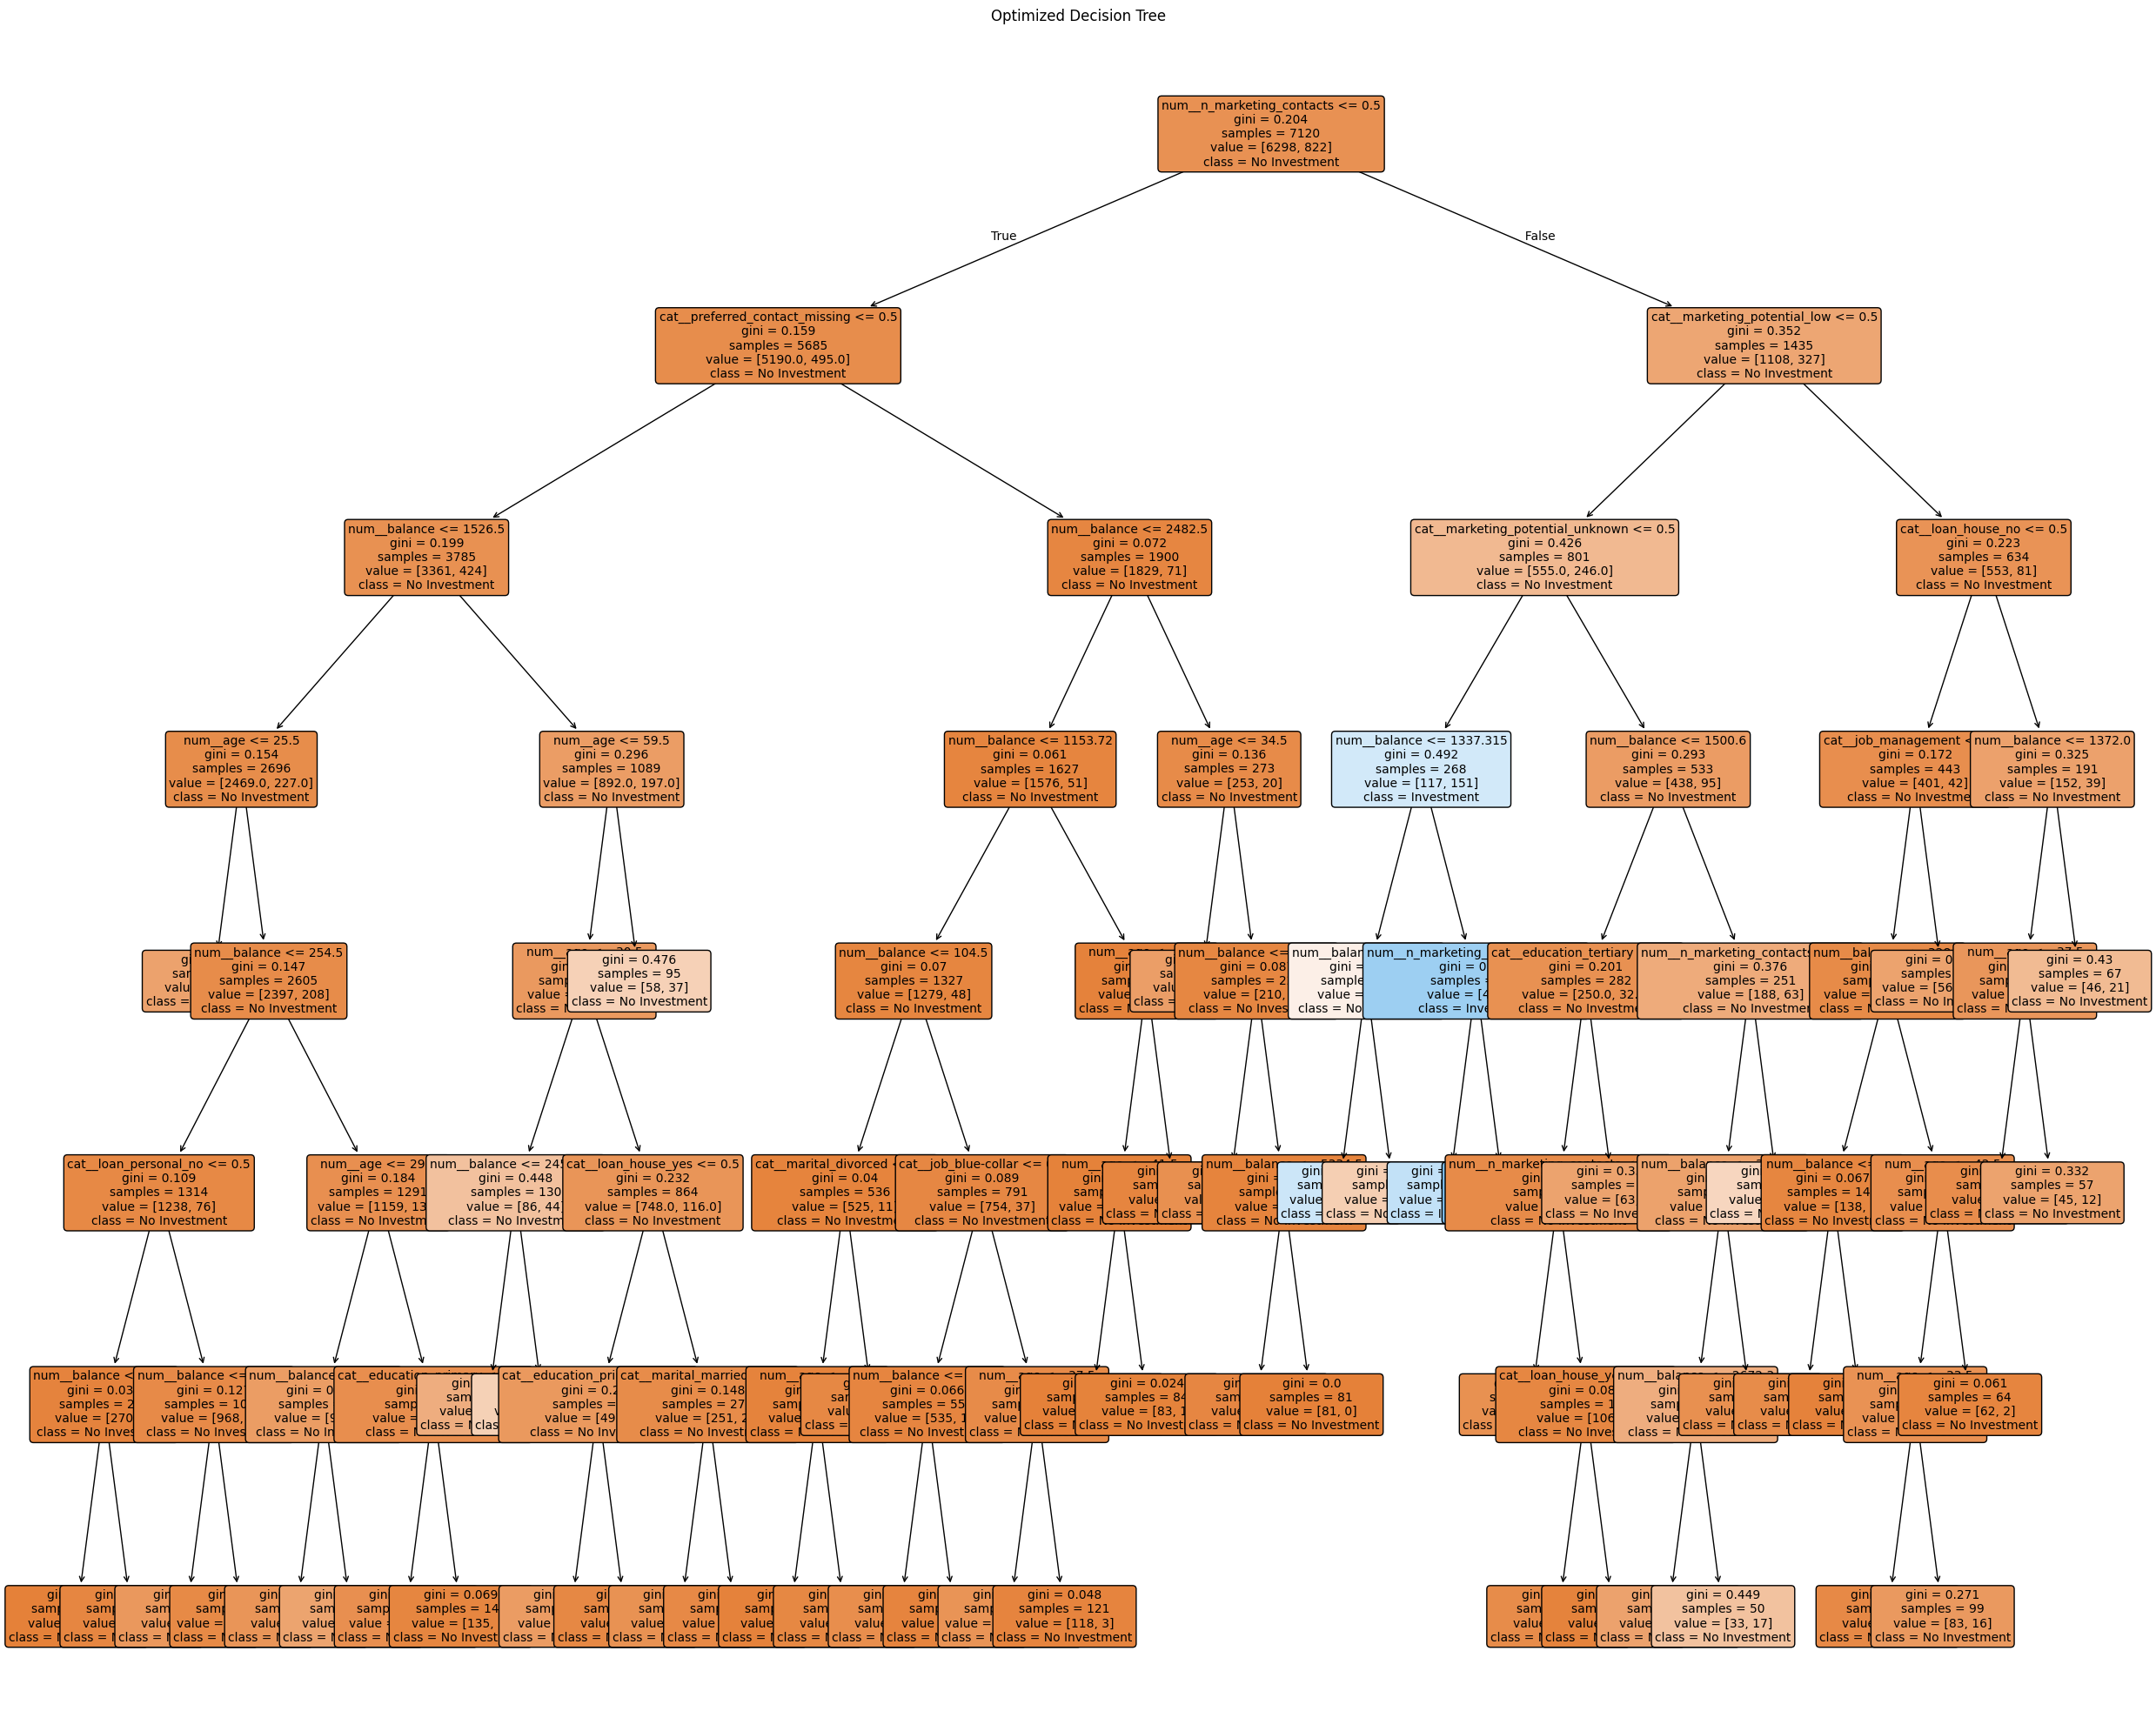

In [79]:
best_tree = cv.best_estimator_.named_steps['classifier']

feature_names_all_dt = cv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
variance_mask_dt = cv.best_estimator_.named_steps['var_filter'].get_support()
selected_features_dt = feature_names_all_dt[variance_mask_dt]

plt.figure(figsize=(25, 20))
tree.plot_tree(best_tree,
               feature_names=selected_features_dt,
               class_names=['No Investment', 'Investment'],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title('Optimized Decision Tree')
plt.tight_layout()
plt.show()

The tree visualization shows the decision rules the model learned. Each node displays the split condition, the number of samples, and the predicted class. Blue nodes lean towards No Investment, orange nodes towards Investment. The limited depth (max_depth=7) keeps the tree interpretable, which is a key advantage over more complex models like Random Forest.